# Car Prediction

Using k-nearest neighbors, we're trying to predict the pricing of the car based on well-known features

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

#print(cars.columns)
#cars.dtypes
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("imports-85.data",names=cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [238]:
#replacing "?" data into numeric for training
#Changing datatypes for numeric values/continuous values
#https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
#only selecting values for Linear Regression

cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
new_cars = cars[cols]
new_cars = new_cars.replace("?",np.nan)
new_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [239]:
#we're replacing all the missing data with average values
new_cars = new_cars.astype(float) #we already filtered out numeric columns
avg_norm_losses = new_cars['normalized-losses'].mean()
#avg_norm_losses
new_cars['normalized-losses'].replace(np.nan, avg_norm_losses,inplace=True)
new_cars.head()
new_cars['normalized-losses'].isnull().sum()

0

In [240]:
#follow the same logic for other columns
cols = new_cars.columns.tolist()
for col in cols:
    if new_cars[col].isnull().sum()  > 0:
        avg = new_cars[col].mean()
        new_cars[col].replace(np.nan,avg,inplace=True)
new_cars.isnull().sum() #woot!

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [241]:
#normalize all columns but the price column (min-max normalization)
cols = new_cars.columns.tolist()
cols.remove("price")
cols

for col in cols:
    max_ = new_cars[col].max()
    min_ = new_cars[col].min()
    mean_ = new_cars[col].mean()
    new_cars[col] = (new_cars[col] - mean_)/(max_ - min_)
new_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,13495.0
1,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,16500.0
2,0.000000,-0.124099,-0.042526,-0.033984,-0.110407,0.103737,-0.464108,0.102180,-0.071409,0.207266,-0.051171,-0.172764,-0.125032,16500.0
3,0.219895,0.030420,0.038071,0.024350,0.047927,-0.084781,-0.099822,0.068846,-0.008909,-0.009401,0.152910,-0.033875,-0.019769,13950.0
4,0.219895,0.018758,0.038071,0.041016,0.047927,0.104125,-0.099822,0.068846,-0.133909,0.044766,0.152910,-0.200542,-0.230295,17450.0


In [242]:
def knn_train_test(k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    knn.fit(train_set[train_col],train_set[target_col])
    hypothesis = knn.predict(test_set[train_col])
    mse = mean_squared_error(test_set[target_col],hypothesis)
    return mse**0.5 #rmse

knn = knn_train_test(10,['horsepower','highway-mpg'],['price'],new_cars)
knn

2353.381880478646

Text(0.5,0,'k-value')

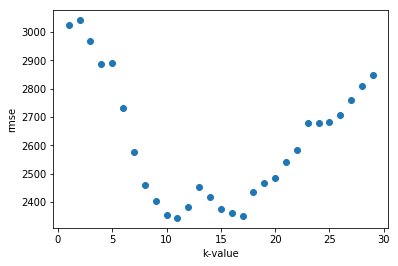

In [243]:
#testing out different k-values, plotting the loss function against k
rmse = list()
for i in range(1,30):
    result = knn_train_test(i,['horsepower','highway-mpg'],['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,30),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#seems like we have 2 good local min at 11 and 17

It seems that we have a double minimum valleys here. In theory, 11 and 17 would be ok. Before that, we have underfitting. After that, we have overfitting.

Text(0.5,0,'k-value')

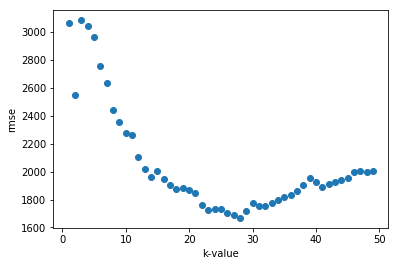

In [244]:
#more columns (all columns)
rmse = list()
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,50),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#we look to be able to reach a min value of ~$1600 error with all parameters
#Generally, more parameters = better but not neccessarily always. Obviously it's still better than previous model

In [245]:
#prevent too much overfitting
#modifying our train function to include cross validation
#n_split for cv validation, k_num for # of k-clusters, train_col = features, target_col = results column,
#df = dataframe
def knn_train_test2(n_split,k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    kf = KFold(n_splits=n_split,shuffle=True,random_state=1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    #knn.fit(train_set[train_col],train_set[target_col])
    mses = cross_val_score(knn,df[train_col],df[target_col],
	scoring="neg_mean_squared_error",cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    rmse = np.mean(rmses)
    #hypothesis = knn.predict(test_set[train_col])
    #mse = mean_squared_error(test_set[target_col],hypothesis)
    return  rmse

knn = knn_train_test2(4,10,['horsepower','highway-mpg'],['price'],new_cars)
knn


3811.0457726512686

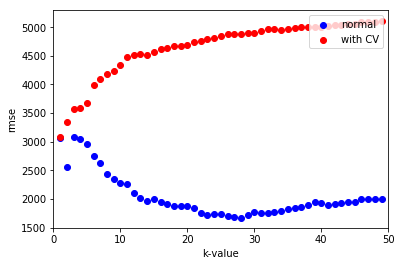

7868.7682123438


In [246]:
rmse = list() #normal
rmse_2 = list() #with cross validation
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(10,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
rmse
plt.close()
plt.scatter(range(1,50),rmse,c='b') 
plt.scatter(range(1,50),rmse_2,c='r')
plt.xlim(0,50)
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
print(new_cars["price"].std())
#is the divergence real? Error is still within 1 std of the price column. There is no local minum seen in the CV function.


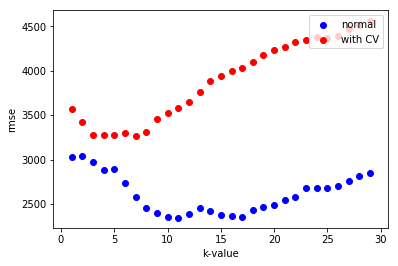

In [247]:
#we know that 2 parameters: ['horsepower','highway-mpg'] affects the price point, let's test out with the cv
cols = ['horsepower','highway-mpg']
rmse = list()
rmse_2 = list()
for i in range(1,30):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(20,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
    
plt.scatter(range(1,30),rmse,c='b')
plt.scatter(range(1,30),rmse_2,c='r')
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
#playing around with the cv splits does help a bit with the full divergence problem.


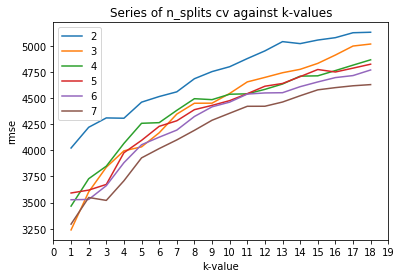

In [248]:
import seaborn as sns

#Let's plot out the number of cross validation splits vs. k-value
cols = new_cars.columns.tolist()
cols.remove('price')
def cv_matrix(n_split, k_num,cols,target,df):
    result = dict() #key= k_num, val=(n_split,error)
    for k in range(1,k_num):
        for n in range(2,n_split):
            rmse = knn_train_test2(n,k,cols,target,df)
            if n not in result:
                result[n] = [0]
            else:
                result[n].append(rmse)
    return result

knn_cv = cv_matrix(8,20,cols,['price'],new_cars)
knn_cv        

for key in knn_cv:
    rmse_results = knn_cv[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values")
plt.show()

Based on this, it seems that we are in the problem of feature engineering instead of matrix modeling building. Let's focus on picking some of the best parameters and assign the needed inputs from there. There's a major problem when there is no local minimum with the matrix.
Plan of attack: We need to find the features that are well-correlated to the price, and only use those to help predict our price. Secondly, we will use an ensemble technique of multiple machine learning algorithms to see which one has the best RMSE

In [249]:
features = new_cars.corr()["price"].sort_values()
print(features)
features1 = features[abs(features) > 0.5]
features2 = features[abs(features) > 0.6]
features3 = features[abs(features) > 0.7]

highway-mpg         -0.690526
city-mpg            -0.667449
peak-rpm            -0.100854
compression-rate     0.070990
stroke               0.082095
normalized-losses    0.133999
height               0.134388
bore                 0.532300
wheel-base           0.583168
length               0.682986
width                0.728699
horsepower           0.757917
curb-weight          0.820825
price                1.000000
Name: price, dtype: float64


Since all of these are continuous values, we'll try to pick a cut off of 0.5 or higher in correlation with price. These would be the most effective parameter that helps us predict the value of the car.

In [250]:
features1 = features1.index.tolist()
features2 = features2.index.tolist()
features3 = features3.index.tolist()

features1.remove("price")
features2.remove("price")
features3.remove("price")

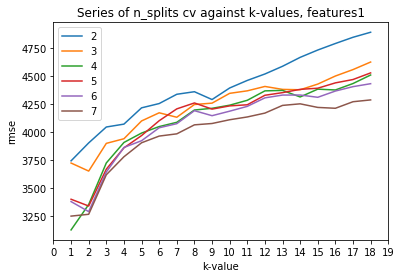

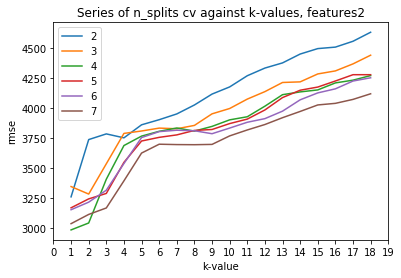

Text(0.5,1,'Series of n_splits cv against k-values, features3')

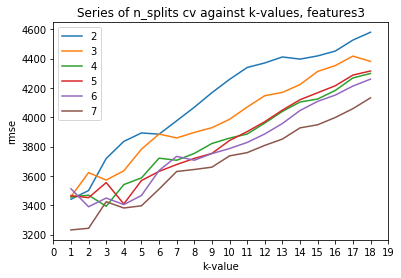

In [251]:
#let's replot our cross matrix
knn_cv1 = cv_matrix(8,20,features1,['price'],new_cars)
knn_cv2 = cv_matrix(8,20,features2,['price'],new_cars)
knn_cv3 = cv_matrix(8,20,features3,['price'],new_cars)

for key in knn_cv1:
    rmse_results = knn_cv1[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features1")
plt.show()


for key in knn_cv2:
    rmse_results = knn_cv2[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features2")
plt.show()

for key in knn_cv3:
    rmse_results = knn_cv3[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features3")


In [252]:
features3

['width', 'horsepower', 'curb-weight']

It seems that features3 ("width","horsepower","curb-weight") seems to give us the most stable result with many different n-splits having and k-values yielding the same RMSE of ~$3400. We can try to look to other algorithms and see if they can provide by improvement

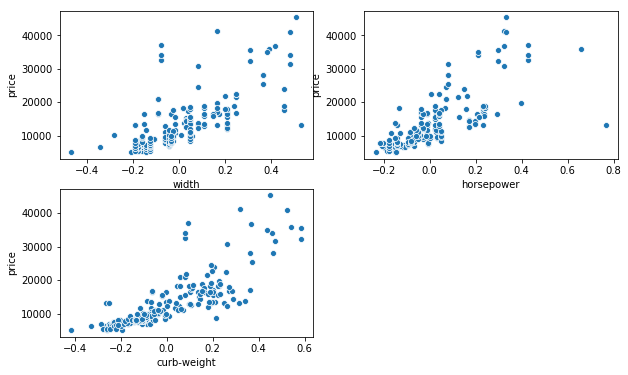

In [253]:
fig = plt.figure(figsize=(10,6))
plt.subplot(221)
sns.scatterplot(new_cars["width"],new_cars["price"])
plt.subplot(222)
sns.scatterplot(new_cars["horsepower"],new_cars["price"])
plt.subplot(223)
sns.scatterplot(new_cars["curb-weight"],new_cars["price"])
plt.show()

These are fairly linear, let's apply a linear regression algorithm to it and see what we can get out of that.

In [254]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
print(new_cars['price'].shape)
#there are simply isn't enough data to help our machine learning algorithm to train/test. However, we'll stick with it and see what we can get.

new_df = shuffle(new_cars,random_state=1)
new_df.head()

(205,)


,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
78,0.204188,-0.147422,-0.249989,-0.125650,-0.243740,-0.213951,-0.256965,-0.012106,-0.046409,-0.151067,0.152910,0.160569,0.190757,6669.000000
97,-0.099476,-0.124099,-0.057452,-0.175650,-0.018740,-0.201150,-0.128394,0.016465,-0.046409,-0.146901,0.030461,0.160569,0.164442,7999.000000
151,-0.183246,-0.089113,-0.229094,-0.192317,0.064593,-0.199987,-0.199822,-0.107344,-0.071409,-0.176067,-0.132804,0.160569,0.190757,6338.000000
44,0.000000,-0.124099,-0.270885,-0.192317,-0.143740,-0.264378,-0.214108,-0.069249,-0.033909,-0.142734,0.112094,0.355014,0.322336,13207.129353
40,-0.193717,-0.065790,0.020160,-0.283984,0.031260,-0.071205,-0.128394,0.154561,-0.071409,-0.076067,0.275359,0.049458,0.059178,10295.000000


In [255]:
def linear_reg(new_cars,features): # a list of features
    new_df = shuffle(new_cars) #no random-state to keep our sampling accurate
    train_x = new_df[features][:180]
    train_y = new_df['price'][:180]
    
    test_x = new_df[features][180:]
    test_y = new_df['price'][180:]

    linear_model = LinearRegression()
    linear_model.fit(train_x,train_y)
    hypothesis = linear_model.predict(test_x)
    rmse = np.sqrt(((hypothesis - test_y)**2).mean())
    return rmse

rmse_linear1 = linear_reg(new_df,features1)
rmse_linear2 = linear_reg(new_df,features2)
rmse_linear3 = linear_reg(new_df,features3)
print(rmse_linear1)
print(rmse_linear2)
print(rmse_linear3)
print("price std: ",new_cars.price.std())

7782.78341521249
4157.958478133465
6061.5539813485075
price std:  7868.7682123438


It is expected for the linear regression to be better with highly correlated parameters in features set #3. However, there isn't enough training data for our model. Therefore, it isn't going to get much better than the knn algorithm
It is also understandable that with the standard deviation of 7000 dollars, a 3000 dollars rmse on our knn is pretty solid.

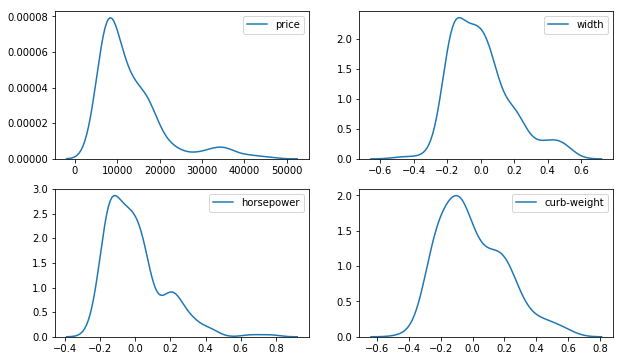

In [256]:
fig = plt.figure(figsize=(10, 6))
plt.subplot(221)
sns.kdeplot(new_cars["price"])
plt.subplot(222)
sns.kdeplot(new_cars["width"])
plt.subplot(223)
sns.kdeplot(new_cars["horsepower"])
plt.subplot(224)
sns.kdeplot(new_cars["curb-weight"])
plt.show()
fig.tight_layout()

Due to the limited amount of data, we'll try to do bootstrapping of our estimator, rmse.

In [257]:
rmse_linear_lst = []
#1000 times
for i in range (0,1000):
    rmse_linear_lst.append(linear_reg(new_df,features3))
print(np.mean(rmse_linear_lst), np.std(rmse_linear_lst))
#rmse_linear_lst

4286.868232552524 1215.727832170137


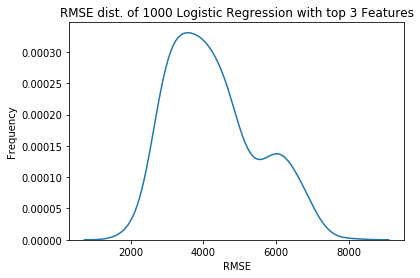

(4211.388874982983, 4362.347590122065)
4286.868232552524 4087.8986437629183 1216.3361523644066


In [258]:
#now we look at the distribution of our frequency plot and finalement, we calculate the quantile to see our confidence level.
import scipy.stats as stats

rmse_linear_lst = pd.Series(rmse_linear_lst)
sns.kdeplot(rmse_linear_lst)
plt.title("RMSE dist. of 1000 Logistic Regression with top 3 Features")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()

#95% confidence interval, with mean and standard errors
def conf_interval_mean(dist, ci=0.95):
    # ppf: Percent Point Function (Inverse of CDF)
    mean, stderr, m = np.mean(dist), stats.sem(dist), stats.t.ppf((1+ci)/2, len(dist)-1)
    lower, upper = (mean-stderr*m, mean+stderr*m)
    return lower,upper
print(conf_interval_mean(rmse_linear_lst,0.95))
print(rmse_linear_lst.mean(),rmse_linear_lst.median(),rmse_linear_lst.std())


In [259]:
#recall that feature set #2 gave us better data on line 220, with $4000 RMSE. Let's see if it's still true here.

rmse_linear_lst2 = []
#1000 times
for i in range (0,1000):
    rmse_linear_lst2.append(linear_reg(new_df,features2))
print(np.mean(rmse_linear_lst2), np.std(rmse_linear_lst2))
#rmse_linear_lst

4410.644872680502 1394.1775219422118


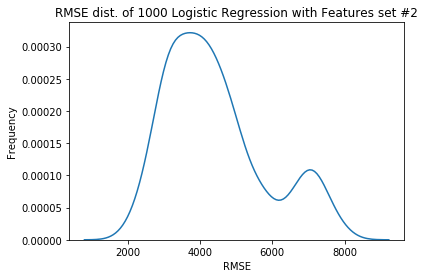

(4324.086334733526, 4497.203410627478)
4410.644872680502 4124.158120431718 1394.8751339558155


In [260]:
#now we look at the distribution of our frequency plot and finalement, we calculate the quantile to see our confidence level.
import scipy.stats as stats

rmse_linear_lst2 = pd.Series(rmse_linear_lst2)
sns.kdeplot(rmse_linear_lst2)
plt.title("RMSE dist. of 1000 Logistic Regression with Features set #2")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()

#95% confidence interval, with mean and standard errors
def conf_interval_mean(dist, ci=0.95):
    # ppf: Percent Point Function (Inverse of CDF)
    mean, stderr, m = np.mean(dist), stats.sem(dist), stats.t.ppf((1+ci)/2, len(dist)-1)
    lower, upper = (mean-stderr*m, mean+stderr*m)
    return lower,upper
print(conf_interval_mean(rmse_linear_lst2,0.95))
print(rmse_linear_lst2.mean(),rmse_linear_lst2.median(),rmse_linear_lst2.std())

Conclusion: It's arguable if this is worse than the previous top 3 features set. However, we can safely say that the 1 time evaluation of Linear Regression did not prove that feature set #2 was a lot better than feature set #3.
It is quite the opposite in fact, and based on the distribution, the mean/median doesn't mean much here.
